In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

In [2]:
f = open("a_b_zeta.txt", "r")
lines = f.readlines()

In [3]:
# 비밀키
a = [ ]

# 암호문
b = []

# zeta
zeta = []

for line in lines:
    temp = []
    for i, value in enumerate(line.split(' ')):
        if i<4:
            # a 값을 저장
            temp.append(value)
            if i == 3:
                a.append(temp)
                temp = []
        elif i<8:
            # b 값을 저장
            temp.append(value)
            if i == 7:
                b.append(temp)
                temp = []
        else:
            # zeta 값을 저장
            temp.append(value)
            if i == 9:
                zeta.append(temp)
                temp = []

In [4]:
a = np.array(a)
b = np.array(b)
zeta = np.array(zeta)

In [5]:
print(a.shape)
print(b.shape)

(100000, 4)
(100000, 4)


In [6]:
temp = []

for i in range(a.shape[0]):
    temp_a = []
    for index, value in enumerate(a[i]):
        if index < 2:
            if index == 0:
                a_1 = np.int16(0)
                a_1 += (np.int16(int(value, 16))<<8)
            else:
                a_1 += (np.int16(int(value, 16)))
                temp_a.append(a_1)
        else:
            if index == 2:
                a_2 = np.int16(0)
                a_2 += (np.int16(int(value, 16))<<8)
            else:
                a_2 += (np.int16(int(value, 16)))
                temp_a.append(a_2)
    temp.append(temp_a)

a = np.array(temp, dtype = 'int16')
a.shape

(100000, 2)

In [7]:
temp = []

for i in range(b.shape[0]):
    temp_b = []
    for index, value in enumerate(b[i]):
        if index < 2:
            if index == 0:
                b_1 = np.int16(0)
                b_1 += (np.int16(int(value, 16))<<8)
            else:
                b_1 += (np.int16(int(value, 16)))
                temp_b.append(b_1)
        else:
            if index == 2:
                b_2 = np.int16(0)
                b_2 += (np.int16(int(value, 16))<<8)
            else:
                b_2 += (np.int16(int(value, 16)))
                temp_b.append(b_2)
    temp.append(temp_b)
b = np.array(temp, dtype = 'int16')
b.shape

(100000, 2)

In [8]:
temp = []

for i in range(zeta.shape[0]):
    temp_b = []
    for index, value in enumerate(zeta[i]):
        if index < 2:
            if index == 0:
                b_1 = np.int16(0)
                b_1 += (np.int16(int(value, 16))<<8)
            else:
                b_1 += (np.int16(int(value, 16)))
                temp_b.append(b_1)
        else:
            if index == 2:
                b_2 = np.int16(0)
                b_2 += (np.int16(int(value, 16))<<8)
            else:
                b_2 += (np.int16(int(value, 16)))
                temp_b.append(b_2)
    temp.append(temp_b)
zeta = np.array(temp, dtype = 'int16')
zeta.shape

(100000, 1)

In [9]:
def montgomery_reduce(a):
    # print(a)
    t = np.int16(0)
    # print("a type", type(a))
    # print("int16_t a ", np.int16(a))
    t = np.int16(a) * np.int16(-3327)
    # print("(int16_t)a * QINV  %d" % t)
    # print("(int32_t)t*KYBER_Q %d" % (np.int32(t) * np.int32(3329)))
    t1 = np.int32(t) * np.int32(3329)
    # print("(a - (int32_t)t*KYBER_Q) %d" %(np.int32(a) - t1))
    t = ((np.int32(a)-(np.int32(t) * np.int32(3329))) >> 16)
    t = np.int16(t)
    # print("t %d" %t)
    return t

def fqmul(a, b):
    # print(type(a))
    # print("a * b = ", np.int32(a) * np.int32(b))
    return montgomery_reduce(np.int32(a) * np.int32(b))

# a = 키
# b = 암호문
def basemul(a, b, zeta):
    r = np.array([0, 0], dtype = 'int16')
    r[0]  = fqmul(np.int16(a[1]), np.int16(b[1]));
    return r[0]
    r[0]  = fqmul(r[0], zeta);
    r[0] += fqmul(a[0], b[0]);
    r[1]  = fqmul(a[0], b[1]);
    r[1] += fqmul(a[1], b[0]);
    return r

In [10]:
def haming_weight(number):
    cnt = 0
    check = 0x1
    for _ in range(16):
        if (number & check):
            cnt +=1
            check = (check << 1)
        else:
            check = (check << 1)
    return cnt

# hw = np.zeros(shape=(0xFFFF,5000))

# # i가 키다
# for i in tqdm(range(0xFFFF)):
#     # j가 평문의 개수
#     for j in range(5000):
#         hw[i][j] = haming_weight(result[i][j])

In [11]:
# def basemul(a, b, zeta):
#     r = np.array([0, 0], dtype = 'int16')
#     r[0]  = fqmul(np.int16(a[1]), np.int16(b[1]));
#     return r[0]
#     r[0]  = fqmul(r[0], zeta);
#     r[0] += fqmul(a[0], b[0]);
#     r[1]  = fqmul(a[0], b[1]);
#     r[1] += fqmul(a[1], b[0]);
#     return r

def fast_fqmul(key, b):
    # r[0] 구하는 단계
    key = np.int16(key)
    b = np.int16(b)
    t2 = np.int32(key) * np.int32(b)
    t3 = np.int16(t2) * np.int16(-3327)
    t4 = np.int32(t3) * np.int32(3329)
    t5 = ((np.int32(t2) - (np.int32(t3) * np.int32(3329))) >> 16)
    t5 = np.int16(t5)
    return t5


In [12]:
from tqdm.notebook import tqdm 

# b = b[:10000]

# t2 = cp.int32()
result = np.int16(np.zeros(shape=(3329,100000)))
vf = np.vectorize(haming_weight)
b_1 = np.array(b[:100000, 1])

for key in tqdm(range(3329)):
    t2 = np.int32(key) * np.int32(b_1)
    t3 = np.int16(t2) * np.int16(-3327)
    t4 = np.int32(t3) * np.int32(3329)
    t5 = ((np.int32(t2) - (np.int32(t3) * np.int32(3329))) >> 16)
    t5 = np.int16(t5)
    result[key] = t5

  0%|          | 0/3329 [00:00<?, ?it/s]

In [13]:
import torch
from tqdm.notebook import tqdm 
traces = np.load("traces.npy")
plt.style.use('seaborn')

torch.cuda.empty_cache()

In [14]:
vf = cp.vectorize(haming_weight)
# re = cp.array(result[:,:5000])
# hw = vf(re)

In [15]:
result.shape

(3329, 100000)

In [16]:
hw = np.zeros(shape=(3329, 100000), dtype = np.int8)
for i in tqdm(range(20)):
    re = cp.array(result[:,i*5000:i*5000+5000])
    hw[:, i*5000:i*5000+5000] = vf(re).get()

  0%|          | 0/20 [00:00<?, ?it/s]

In [17]:
hw_t = hw.T

In [18]:
print(traces.shape)
print(hw.shape)
print(hw_t.shape)

(100000, 600)
(3329, 100000)
(100000, 3329)


In [19]:
traces.shape

(100000, 600)

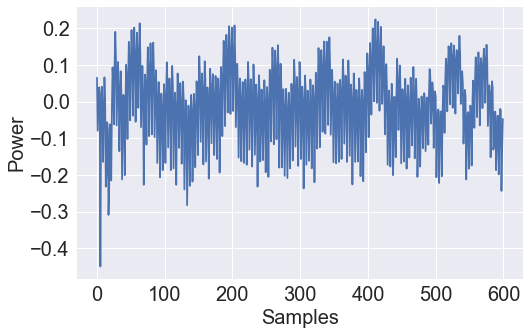

In [20]:
fig, ax = plt.subplots(1,1, figsize = (8, 5))

ax.plot(traces[0])
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

ax.set_xlabel('Samples')
ax.set_ylabel('Power')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [21]:
cor_result = []
limit = 100000
key_limit = 3329
for key in tqdm(range(0,key_limit,1000)):
    if key != 3000:
        temp_hw = hw_t[:,key*1:key*1+1000]
        total = cp.concatenate((cp.array(temp_hw[:limit]), cp.array(traces[:limit])), axis = 1)
        cor = cp.corrcoef(total.T)
        # print(cor.shape)
        temp = []
        for i in range(1000):
            temp.append(cor[i][1000:])
        temp = cp.array(temp)
        cor_result.append(temp)
    else:
        temp_hw = hw_t[:,key*1:]
        total = cp.concatenate((cp.array(temp_hw[:limit]), cp.array(traces[:limit])), axis = 1)
        cor = cp.corrcoef(total.T)
        # print(cor.shape)
        temp = []
        for i in range(329):
            temp.append(cor[i][329:])
        temp = cp.array(temp)
        cor_result.append(temp)

  0%|          | 0/4 [00:00<?, ?it/s]

In [22]:
cor_result_temp = cor_result[0]
for i in range(3):
    cor_result_temp = cp.vstack((cor_result_temp, cor_result[i+1]))

cor_result = cor_result_temp
cor_result.shape

(3329, 600)

* 전력 분석 값에 대해서 -1 값을 곱해준다.
* 이는 Chipwhisperer Lite의 소비 전력 값의 반대로 소비하기 때문이다.

In [25]:
cor_result = cor_result * -1

In [ ]:
from matplotlib.patches import Rectangle
import matplotlib

# fig, ax = plt.subplots(1,1, figsize = (8, 5))
# rect1 = matplotlib.patches.Rectangle((112,-1), 30, 2, color='r', alpha = 1, fill = None, linewidth = 3)
# ax.add_patch(rect1)
# ax.plot(cor_result[1173].get(), linewidth = 3)
# # ax.imshow(cor_result[1173].get())

# ax.xaxis.label.set_size(20)
# ax.yaxis.label.set_size(20)

# plt.xlabel('Samples')
# plt.ylabel('PCC')
# plt.xticks(fontsize = 15)
# plt.yticks(fontsize = 15)
# plt.show()

* 축에 대해서 사이즈를 조정했다.
* 축에 대한 라벨 값을 변경하고 사이즈를 변경했다.

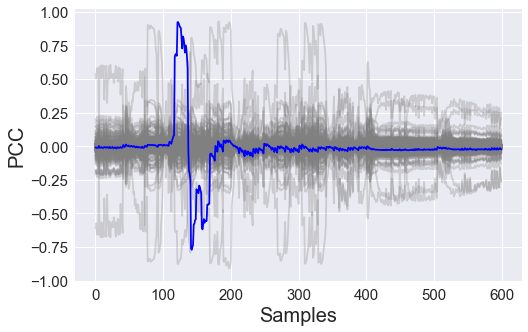

In [26]:
fig, ax = plt.subplots(1,1, figsize = (8, 5))

for i in range(3329):
    if i==1173:
        pass
    else:
        ax.plot(cor_result[i,:].get(),alpha=0.3, color = "gray")     
ax.plot(cor_result[1173].get(), label = "1173", color = "blue")   

x = cp.argmax(cor_result[1173])
y = cp.max(cor_result[1173])

# rect1 = matplotlib.patches.Rectangle((112,-1), 30, 2, color='c', alpha = 0.4)
# ax.add_patch(rect1)

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

plt.xlabel('Samples')
plt.ylabel('PCC')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [28]:
cor_result.shape

(3329, 600)

In [29]:
cp.nanmax(cor_result[:, 120:135], axis = -1)

array([       nan, 0.01404713, 0.00573401, ..., 0.01246084, 0.01494108,
       0.00028165])

In [30]:
cp.where(cor_result[1173] > 0.70)

(array([121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134],
       dtype=int64),)

In [36]:
cp.nanmax(cor_result[1173,120:135])

array(0.92344)

In [35]:
cp.nanmax(cor_result[1044,120:135])

array(0.45993664)

In [33]:
cp.where(cp.nanmax(cor_result[:, 120:135], axis = -1) > 0.4)

(array([1044, 1173], dtype=int64),)

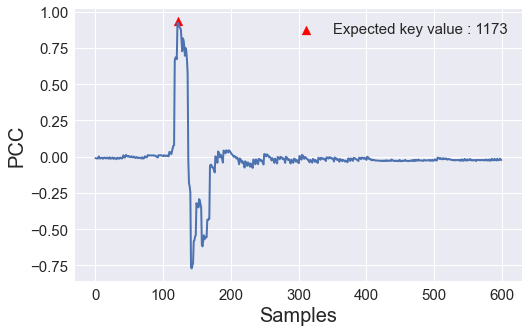

In [37]:
from matplotlib.patches import Rectangle
import matplotlib

fig, ax = plt.subplots(1,1, figsize = (8, 5))
# rect1 = matplotlib.patches.Rectangle((112,-1), 30, 2, color='r', alpha = 1, fill = None, linewidth = 3)
# ax.add_patch(rect1)
ax.plot(cor_result[1173].get(), linewidth = 2)

# ax.imshow(cor_result[1173].get())

x = cp.argmax(cor_result[1173])
y = cp.max(cor_result[1173])

# ax.plot(x.get(), y.get()+0.01, marker = "*", color = 'red', markersize = 13, label = f"Expected key value : {1173}")
ax.scatter(x.get()-0.5, y.get()+0.01, marker = "^", color = 'red', s = 80, label = f"Expected key value : {1173}")

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)



plt.xlabel('Samples')
plt.ylabel('PCC')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

In [38]:
cor_result.shape

(3329, 600)

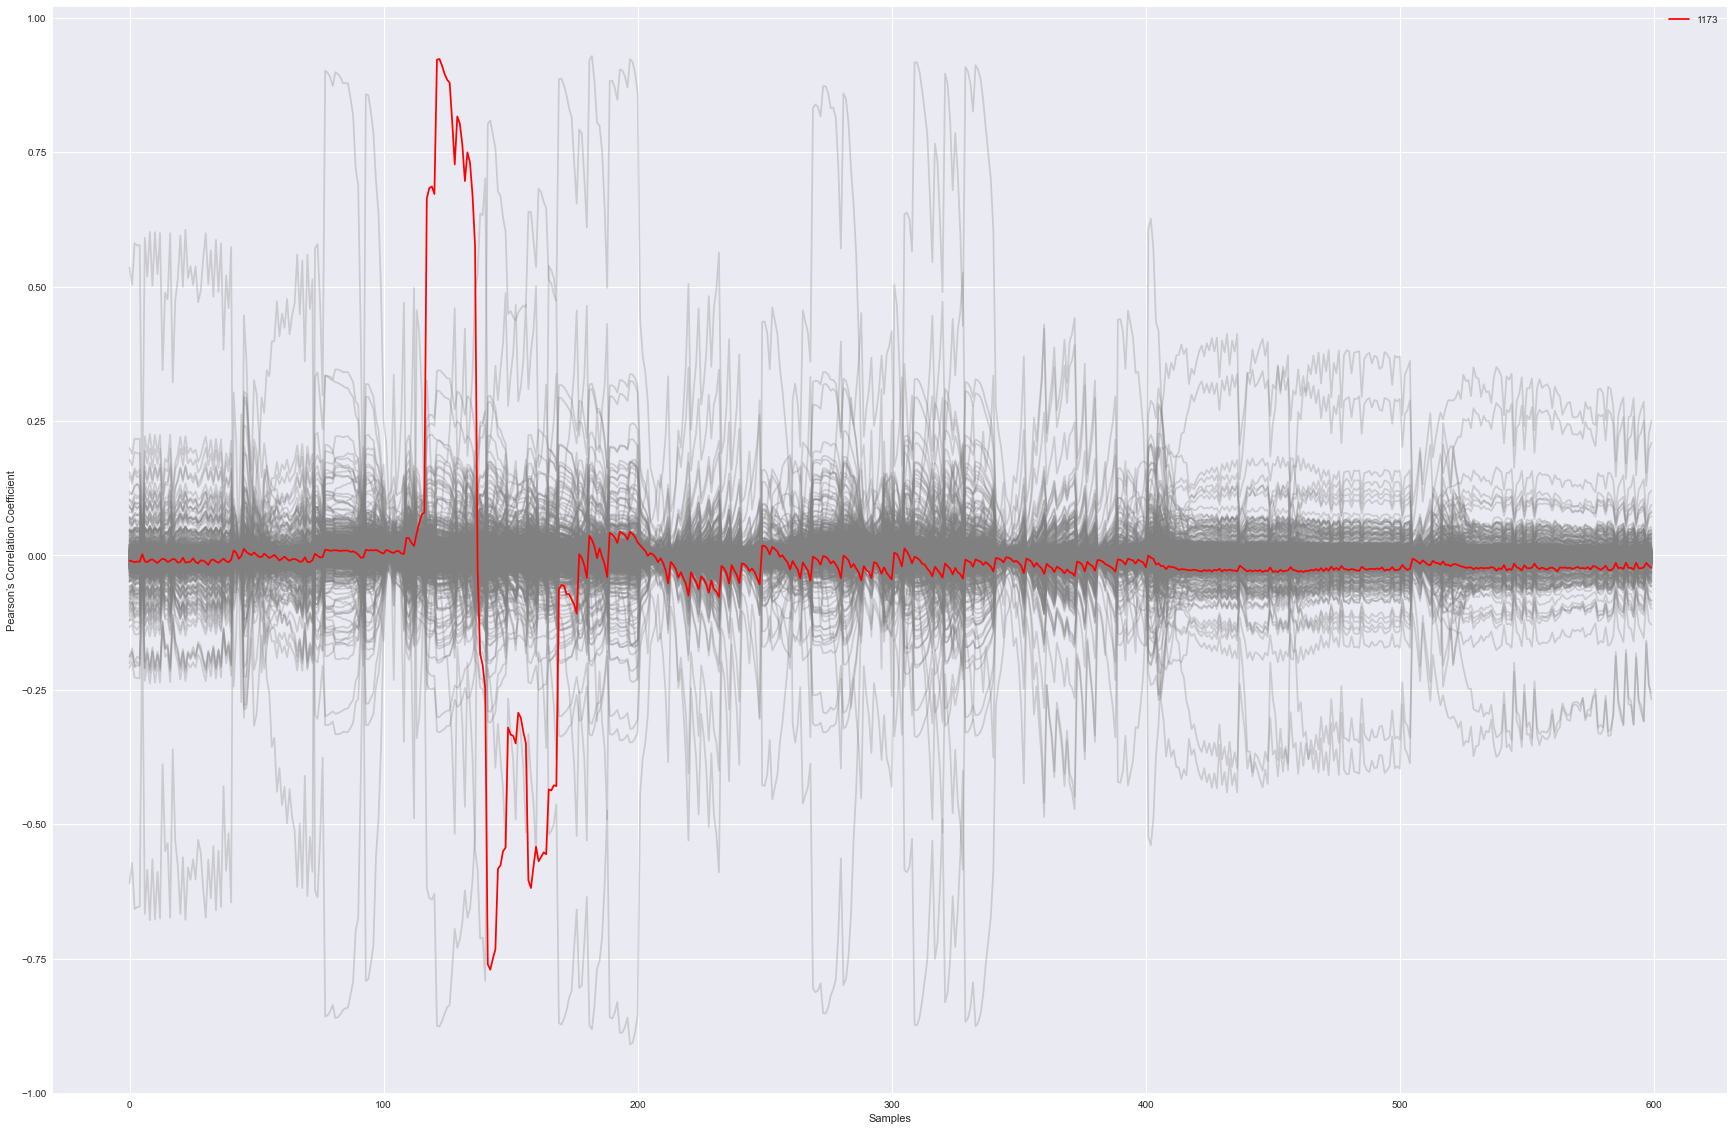

In [41]:
plt.figure(figsize=(30,20))

for i in range(3329):
    if i==1173:
        pass
    else:
        plt.plot(cor_result[i,:].get(),alpha=0.3, color = "gray")           
plt.plot(cor_result[1173].get(), label = "1173", color = "red")
plt.xlabel('Samples')
plt.ylabel('Pearson’s Correlation Coefficient')
plt.legend()
plt.show()

위에서 실제 키에 해당하는 것이 1173이다.<br>
실제 키에서는 대략적으로 110 ~ 140 까지에서 높은 상관 계수를 갖는 것을 볼 수 있다.<br>
따라서, 이러한 범위에서 키와 유사하게 높은 상관 계수를 갖는 것을 찾아 보자.


### 120:140 범위 중에서 상관 계수가 0.4이상을 갖는 키값을 모두 뽑는다.

In [43]:
print(cp.where(cp.nanmax(cor_result[:, 120:140], axis = 1) > 0.4))
# cor_max_reuslt = cp.where(cp.nanmax(cor_result[:, 110:140], axis = 1) > 0.8)[0]

(array([1044, 1173], dtype=int64),)


#### 120:140 범위 중에서 상관 계수가 0.4 이상을 갖는 값들은 총 2개가 존재한다.

* 실제 키값은 1173이고 0.923의 상관 계수를 보여준다.
* 실제 키값이 아닌 1044은 0.459의 상관 계수를 보여준다.

c:\users\lee\appdata\local\programs\python\python37\lib\site-packages\cupy\_statistics\order.py:142: RuntimeWarning: All-NaN slice encountered
  warnings.warn('All-NaN slice encountered', RuntimeWarning)


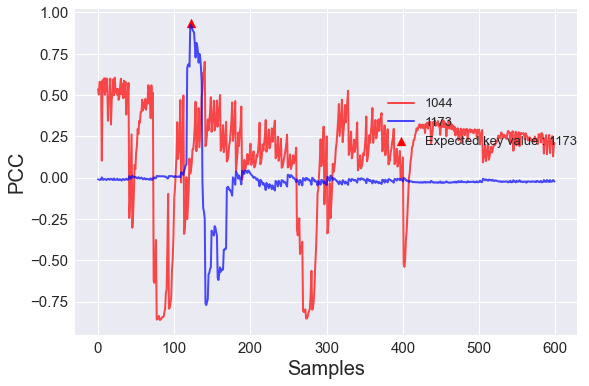

In [70]:
fig, ax = plt.subplots(1, 1, figsize = (9,6))

# 키 후보군을 생성한다.
cor_max_result = cp.where(cp.nanmax(cor_result[:,120:135], axis = -1) > 0.4)[0].get()

# 키 후보군에서 가장 큰 값을 생성한다. 
cor_max_index = cp.nanargmax(cp.nanmax(cor_result[:, 120:135], axis = -1)).get()

cor_x = 0
cor_y = 0

for index in cor_max_result:
    if index != cor_max_index:
        ax.plot(cor_result[index].get(), linewidth = 2, alpha = 0.7, label = f"{index}", color = 'red')
    else:
        # 최고 지점의 x 좌표
        cor_x = cp.nanargmax(cor_result[cor_max_index]).get()
        # 최고 지점의 y 좌표
        cor_y = cp.nanmax(cor_result[cor_max_index]).get()

ax.scatter(cor_x-0.5, cor_y+0.01, marker = "^", color = 'red', s = 80, label = f"Expected key value : {cor_max_index}")        

ax.plot(cor_result[cor_max_index].get(), linewidth = 2, alpha = 0.7, color = 'blue', label = f"{cor_max_index}")
# ax.plot(cor_result[cor_max_index].get(), linewidth = 2, alpha = 1, label = f"{cor_max_index}")


ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

plt.xlabel('Samples')
plt.ylabel('PCC')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 13, loc = 'center left', bbox_to_anchor=(0.6, 0.65))

plt.show()
        
# print(cor_max_index)

In [ ]:
cor_first = cor_result[cor_max_index].get()
print(cor_first.shape)

#### 우리는 그 중에서도 상관 계수가 가장 높은 두 개의 가능한 키값을 통해서 뒤의 연산을 진행 해보도록 하겠다. 실제 키 값은 1173이고 두 번째로 상관 계수가 높은 키 값은 1044이다. 이 두개의 성향을 비교 분석해보자.

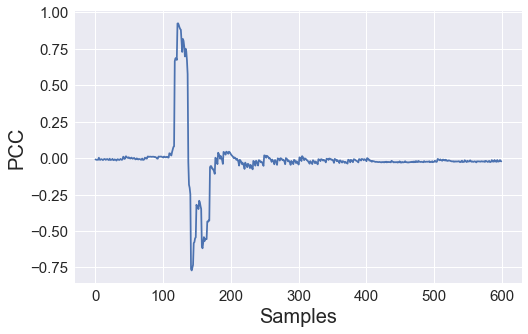

In [51]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))

ax.plot(cor_result[1173].get())

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

plt.xlabel('Samples')
plt.ylabel('PCC')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.show()

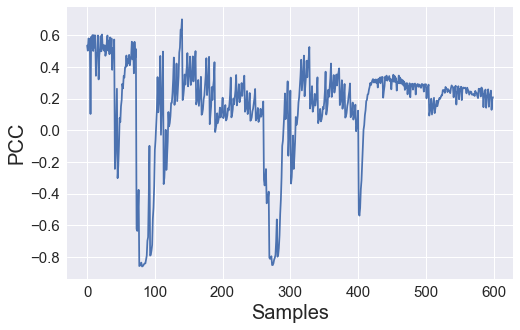

In [52]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))

ax.plot(cor_result[1044].get())

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

plt.xlabel('Samples')
plt.ylabel('PCC')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.show()

#### 실제 키값과 유사한 상관 계수를 갖는 값과 상관 계수가 가장 작은 값에 있어서 HW 분포도는 거의 비슷한 형태를 뛰고 있다. 하지만 세밀한 값의 분포도에서 차이가 있는 것을 알 수 있다.

In [ ]:
ax[0,0].hist(real_hw, bins = 17, edgecolor = 'black')
ax[0,0].set_title("1173_2435", fontsize = 30)

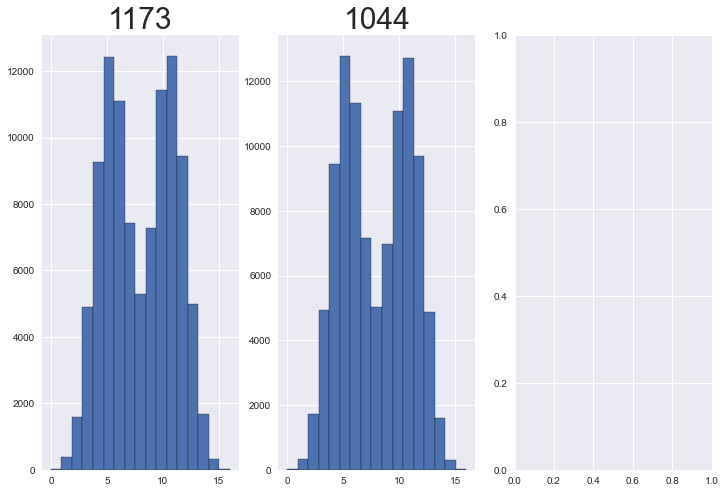

In [53]:
fig, ax = plt.subplots(1,3,figsize = (12, 8))

ax[0].hist(hw[1173], bins = 17, edgecolor = 'black')
ax[0].set_title("1173",fontsize = 30)
ax[1].hist(hw[1044], bins = 17, edgecolor = 'black')
ax[1].set_title("1044",fontsize = 30)
# ax[2].hist(hw[21370], bins = 17, edgecolor = 'black')
# ax[2].set_title("21370",fontsize = 30)


plt.show()

In [ ]:
from collections import Counter

print(Counter(hw[1173]))
print()
print(Counter(hw[4502]))
print()
print(Counter(hw[21370]))

#### 1173과 4502를 키라고 가정하고 그 다음 연산에 있어서 상관 계수를 구해본다.

In [ ]:
cor_max_result

In [54]:
real_result = np.int16(np.zeros(shape=(1,100000)))
fake_result = np.int16(np.zeros(shape=(1,100000)))

real_result[0] = fast_fqmul(1173, b[:,1])
real_result[0] = fast_fqmul(real_result[0], zeta[:,0])

fake_result[0] = fast_fqmul(1044, b[:,1])
fake_result[0] = fast_fqmul(fake_result[0], zeta[:,0])

In [55]:
real_hw = np.zeros(shape=(1,100000), dtype = np.int16)
fake_hw = np.zeros(shape=(1,100000), dtype = np.int16)

In [56]:
real_result[0]

array([    3,  -337,  -541, ..., -1011, -1289, -1455], dtype=int16)

In [57]:
vf = np.vectorize(haming_weight)
real_hw = vf(real_result[0])
fake_hw = vf(fake_result[0])

In [58]:
real_hw = real_hw.reshape(-1, 1)
fake_hw = fake_hw.reshape(-1, 1)

In [59]:
traces.shape

(100000, 600)

In [60]:
total = cp.concatenate((cp.array(real_hw), cp.array(fake_hw), cp.array(traces)), axis=1)

cor = cp.corrcoef(total.T)

real_cor = cor[0,2:]
fake_cor = cor[1,2:]

#### 1173과 1044에 해당하는 키 값이 다음 연산에서 동일한 상관 계수를 갖는 것을 볼 수 있다.

In [61]:
print("상관 계수가 첫 번째로 높은 값 : ", real_result[0][:25])
print()
print("상관 계수가 두 번째로 높은 값 : ", fake_result[0][:25])

상관 계수가 첫 번째로 높은 값 :  [    3  -337  -541   684 -1480 -1032  1116    70  -518  1280  1036   219
   644 -1586  -663    78 -1051  -439  -337  -284  -176   859  1097   295
   138]

상관 계수가 두 번째로 높은 값 :  [  505 -1245  1034 -1375  -568  -612  1436  -423   467  1301  -934   246
   769   453  1581  -186 -1591  1559 -1245   -91  1444  -768   457   833
   -73]


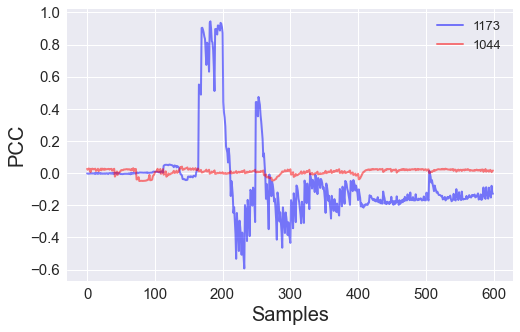

In [71]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))

cor_x = 0
cor_y = 0

ax.plot(real_cor.get()*-1, label = "1173", linewidth = 2, color = "blue", alpha = 0.5)      
ax.plot(fake_cor.get()*-1, label = "1044", linewidth = 2, color = "red", alpha = 0.5)

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

plt.xlabel('Samples')
plt.ylabel('PCC')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 13)

plt.show()
        

In [76]:
real_cor = real_cor * -1
fake_cor = fake_cor * -1

In [ ]:
170 ~ 200

In [81]:
cp.nanmax(real_cor[170:200])

array(0.94469817)

In [82]:
cp.nanmax(fake_cor[170:200])

array(0.0220654)

In [ ]:
cor_two = real_cor.get()
print(cor_two.shape)

#### 다음으로 "r[0] += fqmul(a[0], b[0])" 연산에서 높은 상관 계수를 갖는 a[0]을 추측해 보자.

In [95]:
real_a = np.int16(np.zeros(shape=(3329,100000)))
fake_a = np.int16(np.zeros(shape=(3329,100000)))

vf = np.vectorize(haming_weight)
b_0 = np.array(b[:, 0])

for key in tqdm(range(3329)):
    real_a[key] = fast_fqmul(key, b_0)
    fake_a[key] = fast_fqmul(key, b_0)

  0%|          | 0/3329 [00:00<?, ?it/s]

In [98]:
for key in tqdm(range(3329)):
    real_a[key] += real_result[0]
    fake_a[key] += fake_result[0]

  0%|          | 0/3329 [00:00<?, ?it/s]

In [103]:
real_hw = np.zeros(shape=(3329,100000), dtype = np.int16)
fake_hw = np.zeros(shape=(3329,100000), dtype = np.int16)

In [104]:
vf = cp.vectorize(haming_weight)

for i in tqdm(range(50)):
    re = cp.array(real_a[:,i*2000:i*2000+2000])
    real_hw[:, i*2000:i*2000+2000] = vf(re).get()

  0%|          | 0/50 [00:00<?, ?it/s]

In [105]:
for i in tqdm(range(50)):
    re = cp.array(fake_a[:,i*2000:i*2000+2000])
    fake_hw[:, i*2000:i*2000+2000] = vf(re).get()

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# np.save("3_real_hw", real_hw)
# np.save("3_fake_hw", fake_hw)

# 여기서 위에 hw 불러와

In [ ]:
real_hw = np.load("3_real_hw.npy")
# fake_hw = np.load("3_fake_hw.npy")

In [ ]:
real_hw.shape

In [94]:
real_hw

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [130]:
hw_t = real_hw.T

cor_result = []
limit = 100000
key_limit = 3329
for key in tqdm(range(0,key_limit,1000)):
    if key != 3000:
        temp_hw = hw_t[:,key*1:key*1+1000]
        total = cp.concatenate((cp.array(temp_hw[:limit]), cp.array(traces[:limit])), axis = 1)
        cor = cp.corrcoef(total.T)
        # print(cor.shape)
        temp = []
        for i in range(1000):
            temp.append(cor[i][1000:])
        temp = cp.array(temp)
        cor_result.append(temp)
    else:
        temp_hw = hw_t[:,key*1:]
        total = cp.concatenate((cp.array(temp_hw[:limit]), cp.array(traces[:limit])), axis = 1)
        cor = cp.corrcoef(total.T)
        # print(cor.shape)
        temp = []
        for i in range(329):
            temp.append(cor[i][329:])
        temp = cp.array(temp)
        cor_result.append(temp)
        
cor_result_temp = cor_result[0]
for i in range(3):
    cor_result_temp = cp.vstack((cor_result_temp, cor_result[i+1]))

cor_result = cor_result_temp
cor_result.shape        

  0%|          | 0/4 [00:00<?, ?it/s]

(3329, 600)

In [131]:
cor_result.shape
cor_result *= -1

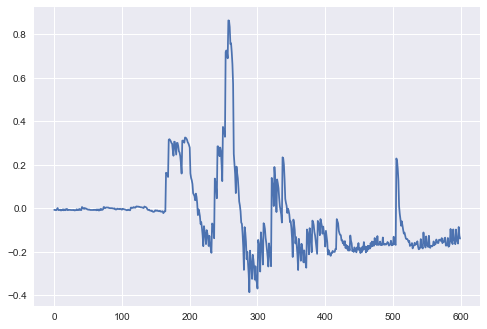

In [132]:
plt.plot(cor_result[2435].get())

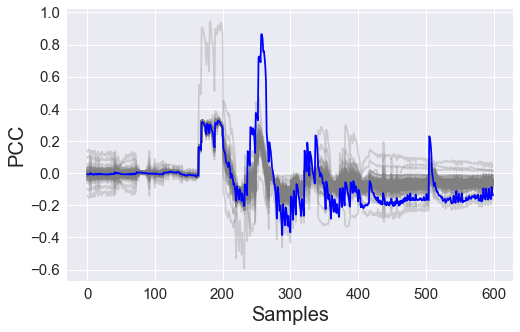

In [133]:
fig, ax = plt.subplots(1,1, figsize = (8, 5))

for i in range(3329):
    if i==2435:
        pass
    else:
        ax.plot(cor_result[i,:].get(),alpha=0.3, color = "gray")     
ax.plot(cor_result[2435].get(), label = "2435", color = "blue")   

x = cp.argmax(cor_result[2435])
y = cp.max(cor_result[2435])

# rect1 = matplotlib.patches.Rectangle((112,-1), 30, 2, color='c', alpha = 0.4)
# ax.add_patch(rect1)

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

plt.xlabel('Samples')
plt.ylabel('PCC')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [134]:
cp.where(cor_result[2435] > 0.8)

(array([257, 258, 259], dtype=int64),)

In [116]:
print(cp.where(cp.nanmax(cor_result[:,250:266], axis = 1) > 0.8))

(array([2435], dtype=int64),)


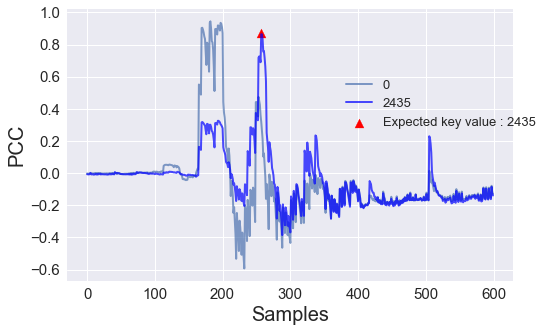

In [121]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))

# 키 후보군을 생성한다.
cor_max_result = cp.where(cp.nanmax(cor_result[:,250:265], axis = -1) > 0.4)[0].get()

# 키 후보군에서 가장 큰 값을 생성한다. 
cor_max_index = cp.nanargmax(cp.nanmax(cor_result[:, 250:265], axis = -1)).get()

cor_x = 0
cor_y = 0

for index in cor_max_result:
    if index != cor_max_index:
        ax.plot(cor_result[index].get(), linewidth = 2, alpha = 0.7, label = f"{index}")
    else:
        # 최고 지점의 x 좌표
        cor_x = cp.nanargmax(cor_result[cor_max_index]).get()
        # 최고 지점의 y 좌표
        cor_y = cp.nanmax(cor_result[cor_max_index]).get()

ax.scatter(cor_x-0.5, cor_y+0.01, marker = "^", color = 'red', s = 80, label = f"Expected key value : {cor_max_index}")        

ax.plot(cor_result[cor_max_index].get(), linewidth = 2, alpha = 0.7, color = 'blue', label = f"{cor_max_index}")
# ax.plot(cor_result[cor_max_index].get(), linewidth = 2, alpha = 1, label = f"{cor_max_index}")


ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

plt.xlabel('Samples')
plt.ylabel('PCC')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 13, loc = 'center left', bbox_to_anchor=(0.6, 0.65))

plt.show()
        
# print(cor_max_index)

In [ ]:
cp.nanmax(cor_result[[ 2435,  5764,  9093, 12422, 54655, 57984, 61313, 64642], 250:266], axis=1)

* fake 구하는 부분이다

In [135]:
hw_t = fake_hw.T

cor_result = []
limit = 100000
key_limit = 3329
for key in tqdm(range(0,key_limit,1000)):
    if key != 3000:
        temp_hw = hw_t[:,key*1:key*1+1000]
        total = cp.concatenate((cp.array(temp_hw[:limit]), cp.array(traces[:limit])), axis = 1)
        cor = cp.corrcoef(total.T)
        # print(cor.shape)
        temp = []
        for i in range(1000):
            temp.append(cor[i][1000:])
        temp = cp.array(temp)
        cor_result.append(temp)
    else:
        temp_hw = hw_t[:,key*1:]
        total = cp.concatenate((cp.array(temp_hw[:limit]), cp.array(traces[:limit])), axis = 1)
        cor = cp.corrcoef(total.T)
        # print(cor.shape)
        temp = []
        for i in range(329):
            temp.append(cor[i][329:])
        temp = cp.array(temp)
        cor_result.append(temp)
        
cor_result_temp = cor_result[0]
for i in range(3):
    cor_result_temp = cp.vstack((cor_result_temp, cor_result[i+1]))

cor_result = cor_result_temp
cor_result.shape        

  0%|          | 0/4 [00:00<?, ?it/s]

(3329, 600)

In [136]:
cor_result *= -1

In [137]:
cor_result

array([[ 2.68964229e-02,  2.09783937e-02,  2.89164961e-02, ...,
         6.56703216e-03,  1.20472835e-02,  1.67800097e-02],
       [ 4.66331483e-03,  3.82572358e-03,  6.50551027e-03, ...,
        -3.42752240e-03,  9.25901816e-04,  6.24648292e-04],
       [ 5.17426528e-03,  5.61505971e-03,  6.43950283e-03, ...,
         3.46807288e-03,  6.29146032e-03,  4.49909075e-03],
       ...,
       [ 2.68045151e-03, -1.72791770e-04,  3.41956542e-05, ...,
        -5.65640966e-03, -3.57434048e-03, -4.86411849e-03],
       [ 1.14169896e-03, -1.11805741e-03,  3.46807290e-03, ...,
        -5.29250194e-03, -4.26003229e-03, -4.70644432e-03],
       [-2.83993566e-03, -7.84568374e-03, -3.55159450e-03, ...,
        -8.07861538e-03, -7.11260552e-03, -5.02939060e-03]])

In [138]:
print(cp.where(cp.nanmin(cor_result[:,255:260], axis = 1) > 0.8))

(array([], dtype=int64),)


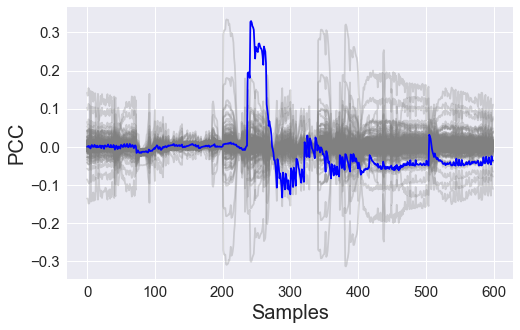

In [139]:
fig, ax = plt.subplots(1,1, figsize = (8, 5))

for i in range(3329):
    if i==2435:
        pass
    else:
        ax.plot(cor_result[i,:].get(),alpha=0.3, color = "gray")     
ax.plot(cor_result[2435].get(), label = "2435", color = "blue")   

x = cp.argmax(cor_result[2435])
y = cp.max(cor_result[2435])

# rect1 = matplotlib.patches.Rectangle((112,-1), 30, 2, color='c', alpha = 0.4)
# ax.add_patch(rect1)

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

plt.xlabel('Samples')
plt.ylabel('PCC')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [ ]:
# plt.plot(cor_two)
# plt.plot(cor_three)
# plt.plot(cor_four)
# plt.plot(cor_five)

In [ ]:
# cor_thee = cor_result[2435].get()

In [ ]:
# plt.plot(cor_three)

위를 통해서도 상관 계수가 높은 것들이 많은 것을 볼 수 있다. 하지만 모든 경우에서 실제 키값을 갖는 경우에 높은 상관 계수를 갖는 것을 알 수 있다. 우리는 위의 과정을 통해서 a[1]의 키값으로는 1173과 4502이 가능한 것을 알 수 있고 a[0]의 키값으로는 2435와 64642이 되는 것을 알 수 있다.

### r[1] 값을 구해서 상관 계수를 구해보자. a[0]은 2435와 64642를 사용하자.

In [ ]:
real_result = np.int16(np.zeros(shape=(1,100000)))
fake_result = np.int16(np.zeros(shape=(1,100000)))

# r[1]을 구하는 식이다.
real_result[0] = fast_fqmul(2435, b[:,1])

fake_result[0] = fast_fqmul(64642, b[:,1])

In [ ]:
real_hw = np.zeros(shape=(1,100000), dtype = np.int16)
fake_hw = np.zeros(shape=(1,100000), dtype = np.int16)

vf = np.vectorize(haming_weight)
real_hw = vf(real_result[0])
fake_hw = vf(fake_result[0])

In [ ]:
real_hw = real_hw.reshape(-1, 1)
fake_hw = fake_hw.reshape(-1, 1)

In [ ]:
total = cp.concatenate((cp.array(real_hw), cp.array(fake_hw), cp.array(traces)), axis=1)

cor = cp.corrcoef(total.T)

real_cor = cor[0,2:]
fake_cor = cor[1,2:]

* r[0] += fqmul(a[0], b[0]);
* r[1]  = fqmul(a[0], b[1]);

위의 두 과정에서 a[0]이 사용되었고 우리는 2435와 64642 둘 중에서 키 값이 될 수 있다는 것을 확인했다. 그런데 두 상황에서 모두 2435의 상관 계수가 높기 때문에 이 값이 실제 키 값일 것이다.

In [ ]:
real_cor *= -1
fake_cor *= -1

In [ ]:
plt.style.use('seaborn')

fig, ax = plt.subplots(1,1, figsize = (10, 7))
     
ax.plot(fake_cor.get(), label = "64642", color = "red", alpha = 0.5, linewidth = 3)   
ax.plot(real_cor.get(), label = "2435", color = "blue", alpha = 0.5, linewidth = 3)

# rect1 = matplotlib.patches.Rectangle((112,-1), 30, 2, color='c', alpha = 0.4)
# ax.add_patch(rect1)

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

plt.xlabel('Samples')
plt.ylabel('PCC')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()
plt.show()

In [ ]:
cor_four = real_cor.get()

In [ ]:
real_result.shape

### 2435를 키라고 가정하고 위에서 정하지 못한 a[1] 값을 정해 보자. a[1]은 1173, 4502 둘 중에서 하나이다.

In [ ]:
import copy

In [ ]:
real_result2 = copy.deepcopy(real_result)
fake_result2 = copy.deepcopy(fake_result)

In [ ]:
# 1173으로 가정한 것이 real_result가 된다.
# fake_result는 4502로 가정한다.
# fake_result = copy.deepcopy(real_result)

b_0 = np.array(b[:, 0])

real_result += fast_fqmul(1173, b_0) # 2435
fake_result += fast_fqmul(1173, b_0) # 64642

real_result2 += fast_fqmul(4502, b_0)# 2435
fake_result2 += fast_fqmul(4502, b_0) # 64642

In [ ]:
real_hw = np.zeros(shape=(1,100000), dtype = np.int16)
fake_hw = np.zeros(shape=(1,100000), dtype = np.int16)

real_hw2 = np.zeros(shape=(1,100000), dtype = np.int16)
fake_hw2 = np.zeros(shape=(1,100000), dtype = np.int16)

vf = np.vectorize(haming_weight)
real_hw = vf(real_result[0])
fake_hw = vf(fake_result[0])

real_hw2 = vf(real_result2[0])
fake_hw2 = vf(fake_result2[0])

In [ ]:
real_hw = real_hw.reshape(-1, 1)
fake_hw = fake_hw.reshape(-1, 1)

total = cp.concatenate((cp.array(real_hw), cp.array(fake_hw), cp.array(traces)), axis=1)

cor = cp.corrcoef(total.T)

real_cor = cor[0,2:]
fake_cor = cor[1,2:]

In [ ]:
real_hw2 = real_hw2.reshape(-1, 1)
fake_hw2 = fake_hw2.reshape(-1, 1)

total2 = cp.concatenate((cp.array(real_hw2), cp.array(fake_hw2), cp.array(traces)), axis=1)

cor2 = cp.corrcoef(total2.T)

real_cor2 = cor2[0,2:]
fake_cor2 = cor2[1,2:]

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(2,2, figsize = (16, 16))



ax[0,0].hist(real_hw, bins = 17, edgecolor = 'black')
ax[0,0].set_title("1173_2435", fontsize = 30)
ax[0,1].hist(fake_hw, bins = 17, edgecolor = 'black')
ax[0,1].set_title("1173_64642", fontsize = 30)

ax[1,0].hist(real_hw2, bins = 17, edgecolor = 'black')
ax[1,0].set_title("4502_2435", fontsize = 30)
ax[1,1].hist(fake_hw2, bins = 17, edgecolor = 'black')
ax[1,1].set_title("4502_64642", fontsize = 30)



plt.legend()
plt.show()

In [ ]:
print(real_cor[:10])
print(real_cor2[:10])

In [ ]:
print(cp.max(real_cor))
print(cp.max(fake_cor))

print(cp.max(real_cor2))
print(cp.max(fake_cor2))

In [ ]:
cp.argmax(real_cor).get()

In [ ]:
# real_cor = real_cor * -1
# fake_cor = fake_cor * -1

fig, ax = plt.subplots(1,1, figsize = (20, 15))
ax.plot(fake_cor.get(), label = "1173_64642", alpha = 0.5, linewidth = 4)   
ax.plot(real_cor.get(), label = "1173_2435", alpha = 0.9, linewidth = 4)

ax.plot(fake_cor2.get(), label = "4502_64642", alpha = 0.5, linewidth = 4)   
ax.plot(real_cor2.get(), label = "4502_2435", alpha = 0.5, linewidth = 4)

# rect1 = matplotlib.patches.Rectangle((112,-1), 30, 2, color='c', alpha = 0.4)
# ax.add_patch(rect1)

cor_x = cp.argmax(real_cor).get()
cor_y = cp.max(real_cor).get()
ax.scatter(cor_x-0.5, cor_y+0.01, marker = "^", color = 'red', s = 200, label = f"Expected key value : 1173_2435")        


ax.xaxis.label.set_size(30)
ax.yaxis.label.set_size(30)

plt.xlabel('Samples')
plt.ylabel('PCC')
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(fontsize = 35)
plt.show()

In [ ]:
real_cor2 = real_cor2 * -1
fake_cor2 = fake_cor2 * -1

fig, ax = plt.subplots(1,1, figsize = (20, 15))
     
ax.plot(fake_cor2.get(), label = "64642", color = "red", alpha = 0.5, linewidth = 4)   
ax.plot(real_cor2.get(), label = "2435", color = "blue", alpha = 0.5, linewidth = 4)

# rect1 = matplotlib.patches.Rectangle((112,-1), 30, 2, color='c', alpha = 0.4)
# ax.add_patch(rect1)

ax.xaxis.label.set_size(30)
ax.yaxis.label.set_size(30)

plt.xlabel('Samples')
plt.ylabel('PCC')
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(fontsize = 35)
plt.show()

In [ ]:
plt.figure(figsize=(20,15))

plt.plot(real_cor.get(), label = "1173", color = "red", alpha = 0.5, linewidth = 4)      
plt.plot(fake_cor.get(), label = "4502", color = "blue", alpha = 0.5, linewidth = 4)

plt.legend()
plt.show()

In [ ]:
cor_five = real_cor.get()

In [ ]:
plt.plot(cor_five)

In [ ]:
cor_two *= -1
cor_three *= -1
cor_four *= -1
cor_five *= -1

In [ ]:
plt.plot(cor_first)
plt.plot(cor_two)
plt.plot(cor_three)
plt.plot(cor_four)
plt.plot(cor_five)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))

ax.plot(traces[0], color = 'gray')
ax.plot(cor_first, label = "1's fqmul",alpha = 0.8)
ax.plot(cor_two, label = "2's fqmul",alpha = 0.8)
ax.plot(cor_three, label = "3's fqmul",alpha = 0.8)
ax.plot(cor_four, label = "4's fqmul",alpha = 0.8)
ax.plot(cor_five, label = "5's fqmul",alpha = 0.5, color = 'orange')


ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

plt.xlabel('Samples')
plt.ylabel('')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()

plt.show()

In [ ]:
print(cp.nanmin(real_cor))
print(cp.nanmin(fake_cor))

In [ ]:
b_0 = np.array(b[:, 0])

for key in tqdm(range(0xFFFF)):
    real_a[key] = fast_fqmul(key, b_0)
    fake_a[key] = fast_fqmul(key, b_0)


r[0]  = fqmul(np.int16(a[1]), np.int16(b[1]));
    r[0]  = fqmul(r[0], zeta);
    r[0] += fqmul(a[0], b[0]);`
    r[1]  = fqmul(a[0], b[1]);
    r[1] += fqmul(a[1], b[0]);